##  Titanic Competition

In [ ]:
#!pip install dabl
#!pip install missingno 

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn.experimental import enable_iterative_imputer
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
import dabl 
import re
import warnings
warnings.filterwarnings('ignore')

/Users/daniel/miniforge3/envs/mlp/lib/python3.8/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [3]:
## Import Data set
train_df = pd.read_csv('../data/titanic/train.csv')
test_df = pd.read_csv('../data/titanic/test.csv')
sub = pd.read_csv('../data/titanic/gender_submission.csv')


## Data Engineering 

In [4]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:

patt ='(Mr|Miss|Master|Mrs|Dr|Rev|Mme|Major|Mlle|Rev|Don|Ms|Col|Capt|Countess|Jonkheer)'
train_df['Title'] = train_df['Name'].apply(lambda x : re.findall(patt,x)[0])
train_df['Title'] = train_df['Title'].replace('Don','Mr')
train_df['Title'] = train_df['Title'].replace('Mlle', 'Miss')
train_df['Title'] = train_df['Title'].replace('Ms', 'Miss')
train_df['Title'] = train_df['Title'].replace('Mme', 'Mrs')
train_df['Title'] = train_df['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona','Mrs'], 'Other')
train_df = train_df.drop(['PassengerId','Name','Ticket'], axis=1)
train_df['Cabin'] = train_df['Cabin'].str.extract('([A-Za-z])', expand=False)
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title
0,0,3,male,22.0,1,0,7.2500,NaN,S,Mr
1,1,1,female,38.0,1,0,71.2833,C,C,Mr
2,1,3,female,26.0,0,0,7.9250,NaN,S,Miss
3,1,1,female,35.0,1,0,53.1000,C,S,Mr
4,0,3,male,35.0,0,0,8.0500,NaN,S,Mr


## Exploratory Data Analysis 

In [6]:
train_df[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


Text(0.5, 0, 'Gender')

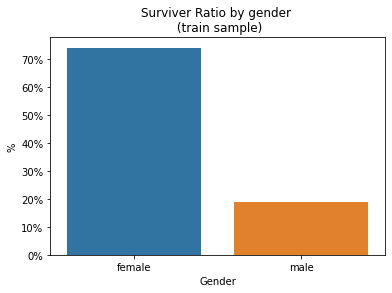

In [7]:
ratio_survivor_gender = train_df[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)
ratio_survivor_gender['Survived'] = ratio_survivor_gender['Survived']*100
ratio_bar = sns.barplot(x='Sex',y='Survived',data = ratio_survivor_gender)
ratio_bar.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title("Surviver Ratio by gender \n (train sample)")
plt.ylabel("%")
plt.xlabel("Gender")

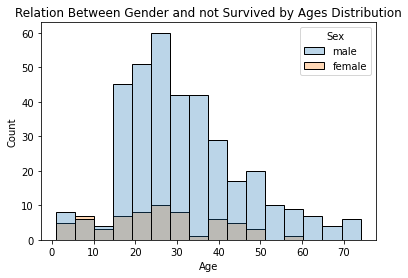

In [8]:
## Relation age - gender versus survived
# 0 = No supervived
no_surviver = train_df[train_df['Survived']==0]
sns.histplot(x='Age', hue='Sex',alpha=0.3,data=no_surviver)
plt.title("Relation Between Gender and not Survived by Ages Distribution")
plt.show()


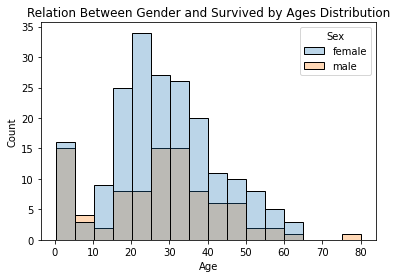

In [9]:
surviver = train_df[train_df['Survived']==1]
sns.histplot(x='Age', hue='Sex',alpha=0.3,data=surviver)
plt.title("Relation Between Gender and Survived by Ages Distribution")
plt.show()

## Exploring Relations and missing Values

## Iterative Imputer Ages

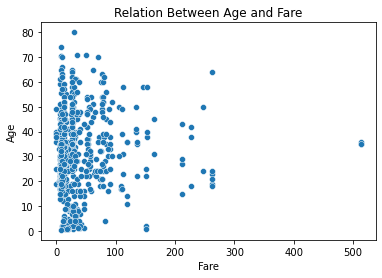

In [10]:
sns.scatterplot(x='Fare',y='Age',data=train_df)
plt.title('Relation Between Age and Fare')
plt.show()

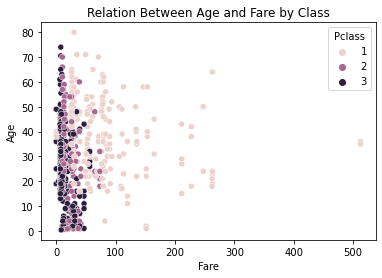

In [11]:
sns.scatterplot(x='Fare',y='Age',hue='Pclass',data=train_df)
plt.title('Relation Between Age and Fare by Class')
plt.show()

Remove candidate anomaly data elements

In [ ]:
#train_df = train_df[train_df['Fare']<150]
#train_df = train_df.reset_index(drop=True)

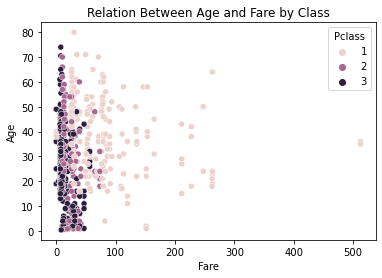

In [12]:
sns.scatterplot(x='Fare',y='Age',hue='Pclass',data=train_df)
plt.title('Relation Between Age and Fare by Class')
plt.show()

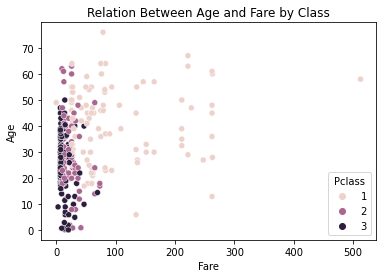

In [13]:
sns.scatterplot(x='Fare',y='Age',hue='Pclass',data=test_df)
plt.title('Relation Between Age and Fare by Class')
plt.show()

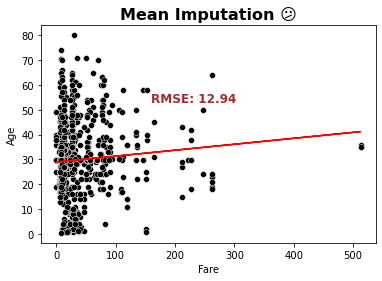

In [14]:
expr_cols = ['Age','Fare']
mean_imputer = SimpleImputer(strategy='mean')
mean_imputed = mean_imputer.fit_transform(train_df[expr_cols])
titanic_mean_imputed = pd.DataFrame(mean_imputed, columns=expr_cols)
x = titanic_mean_imputed.Fare
y = titanic_mean_imputed.Age
sns.scatterplot(x, y, color='black')
m, b = np.polyfit(x, y, 1)
linreg = m*x + b
rmse = round(mean_squared_error(y, linreg, squared=False), 3)
plt.plot(x, linreg, color='Red')
plt.title('Mean Imputation 😕', fontsize=16, fontweight='bold')
plt.text(160, 53, f'RMSE: {rmse}', fontsize=12, fontweight='bold',color='brown')
plt.show()

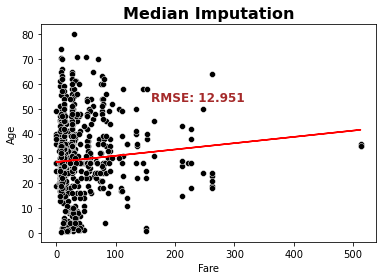

In [15]:
median_imputer = SimpleImputer(strategy='median')
median_imputed = median_imputer.fit_transform(train_df[expr_cols])
titanic_median_imputed = pd.DataFrame(median_imputed, columns=expr_cols)
x = titanic_median_imputed.Fare
y = titanic_median_imputed.Age
sns.scatterplot(x, y, color='black')
m, b = np.polyfit(x, y, 1)
linreg = m*x + b
rmse = round(mean_squared_error(y, linreg, squared=False), 3)
plt.plot(x, linreg, color='Red')
plt.title('Median Imputation', fontsize=16, fontweight='bold')
plt.text(160, 53, f'RMSE: {rmse}', fontsize=12, fontweight='bold',color='brown')
plt.show()

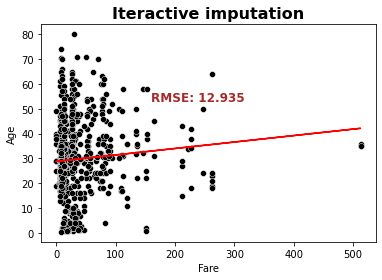

In [16]:
iter_imputer = IterativeImputer(random_state=42)
iter_imputed = iter_imputer.fit_transform(train_df[expr_cols])
titanic_iter_imputed = pd.DataFrame(iter_imputed, columns=expr_cols)
x = titanic_iter_imputed.Fare
y = titanic_iter_imputed.Age
sns.scatterplot(x, y, color='black')
m, b = np.polyfit(x, y, 1)
linreg = m*x + b
rmse = round(mean_squared_error(y, linreg, squared=False), 3)
plt.plot(x, linreg, color='Red')
plt.title('Iteractive imputation', fontsize=16, fontweight='bold')
plt.text(160, 53, f'RMSE: {rmse}', fontsize=12, fontweight='bold',color='brown')
plt.show()

In [17]:
train_df['Age']=titanic_iter_imputed['Age']

<AxesSubplot:>

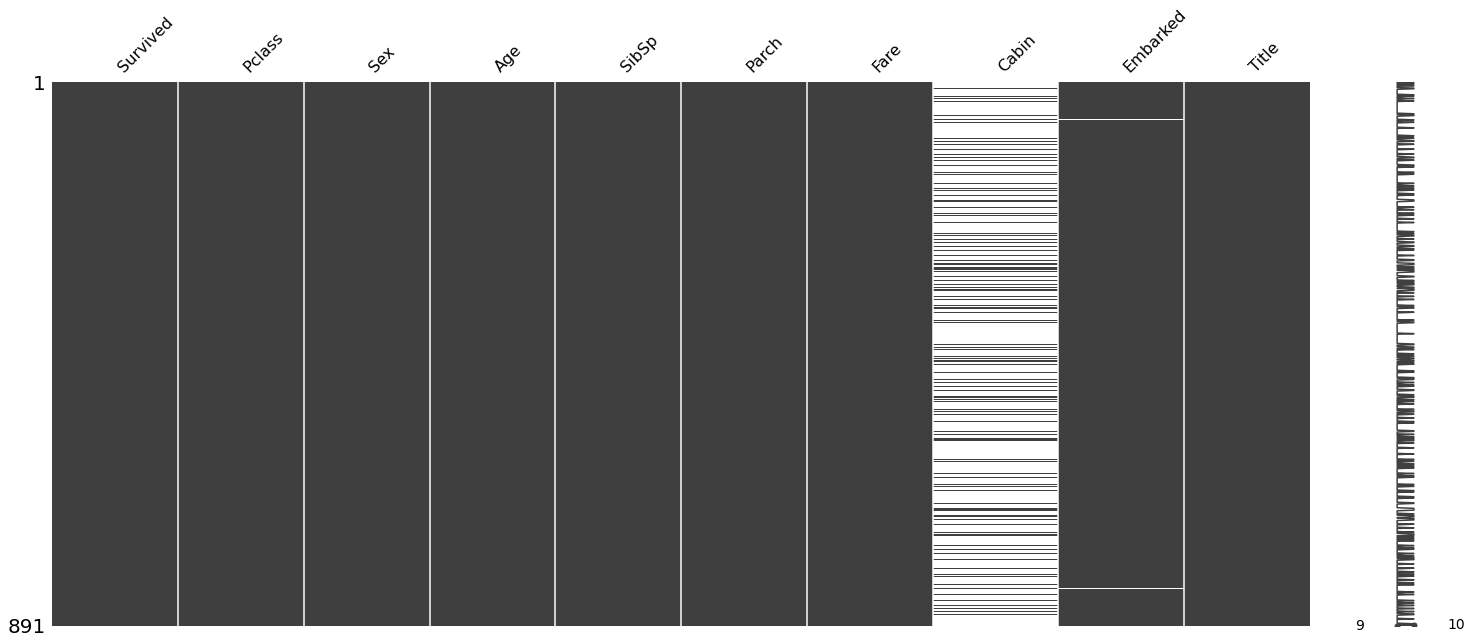

In [18]:
msno.matrix(train_df)

In [19]:
train_df.isna().sum().sort_values(ascending=False)

Cabin       687
Embarked      2
Survived      0
Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Title         0
dtype: int64

In [20]:
train_df = train_df.drop(['Cabin'],axis=1).dropna(subset=['Embarked'])
train_df = train_df.reset_index(drop=True)

In [21]:
ratio_survivor = train_df[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)
ratio_survivor['Not Survived'] = 1 - ratio_survivor['Survived']
ratio_survivor

,Sex,Survived,Not Survived
0,female,0.740385,0.259615
1,male,0.188908,0.811092


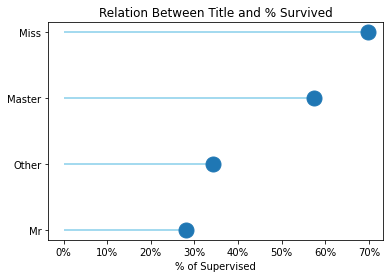

In [22]:
ratio_survivor_title=train_df[["Title", "Survived"]].groupby(['Title'], as_index=False).mean().sort_values(by='Survived', ascending=False)
ordered_df = ratio_survivor_title.sort_values(by='Survived').reset_index(drop=True)
my_range = range(1, len(ratio_survivor_title.index) + 1)

plt.hlines(y=my_range, 
           xmin=0, 
           xmax=ordered_df['Survived'],
           color='skyblue')
current_values = plt.gca().get_xticks()
plt.yticks(ordered_df.index+1, ordered_df['Title'])
plt.plot(ordered_df['Survived'], my_range, 'o', markersize=15)
plt.gca().set_xticklabels(['{:,.0%}'.format(x) for x in current_values])
plt.title("Relation Between Title and % Survived")
plt.xlabel('% of Supervised')
plt.show()

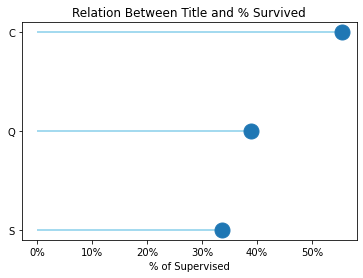

In [23]:
ratio_survivor_embarked=train_df[["Embarked", "Survived"]].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)
ordered_df = ratio_survivor_embarked.sort_values(by='Survived').reset_index(drop=True)
my_range = range(1, len(ratio_survivor_embarked.index) + 1)

plt.hlines(y=my_range, 
           xmin=0, 
           xmax=ordered_df['Survived'],
           color='skyblue')
current_values = plt.gca().get_xticks()
plt.yticks(ordered_df.index+1, ordered_df['Embarked'])
plt.plot(ordered_df['Survived'], my_range, 'o', markersize=15)
plt.gca().set_xticklabels(['{:,.0%}'.format(x) for x in current_values])
plt.title("Relation Between Title and % Survived")
plt.xlabel('% of Supervised')
plt.show()

In [24]:
def dist_age_embarked(Letter):
    ax =sns.histplot(x='Age',hue='Sex',data=train_df[train_df['Embarked']==Letter])
    plt.title("Age distribution at {} Embarked".format(Letter))
    plt.show()
    return(ax)
    

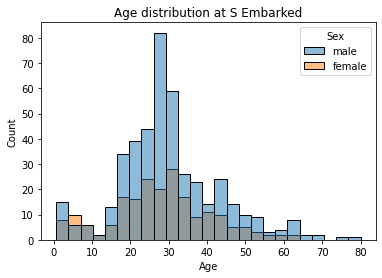

AxesSubplot(0.125,0.125;0.775x0.755)


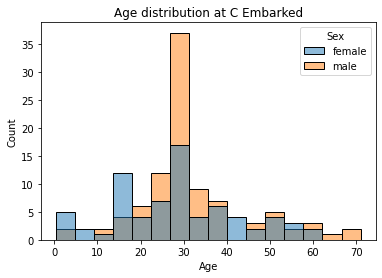

AxesSubplot(0.125,0.125;0.775x0.755)


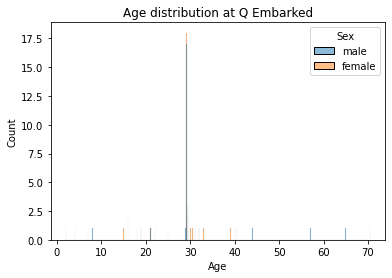

AxesSubplot(0.125,0.125;0.775x0.755)


In [25]:
for i in train_df['Embarked'].dropna().drop_duplicates():
    print(dist_age_embarked(i))

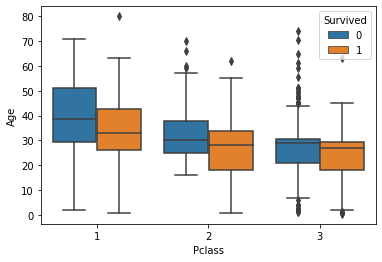

In [26]:
sns.boxplot(x='Pclass',y='Age', hue='Survived',data=train_df)
plt.show()

With the data clean, normalizated and without outlier, is possible start with Masive EDA

Target looks like classification
Linear Discriminant Analysis training set score: 0.588


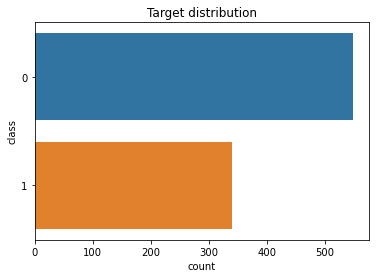

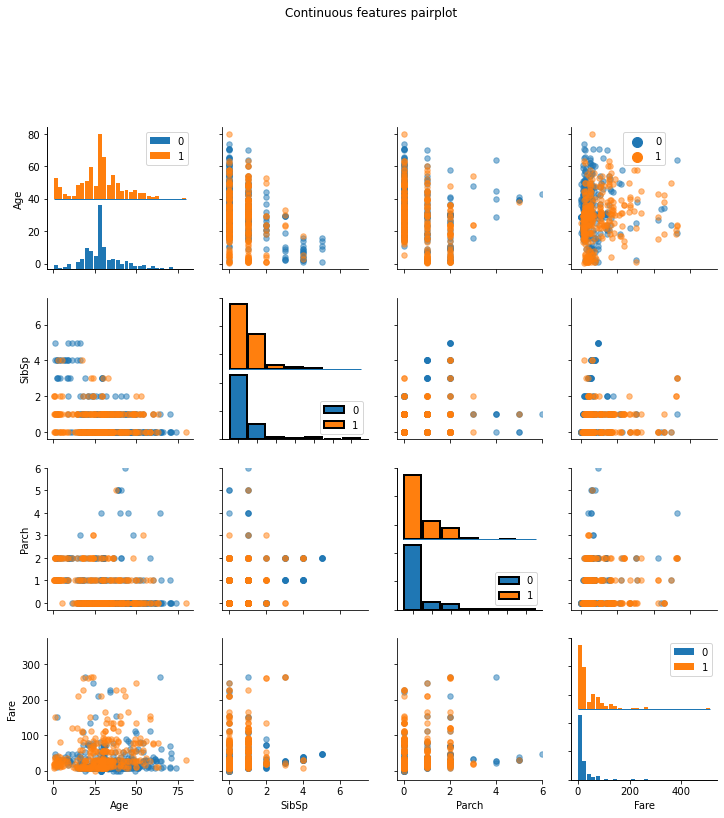

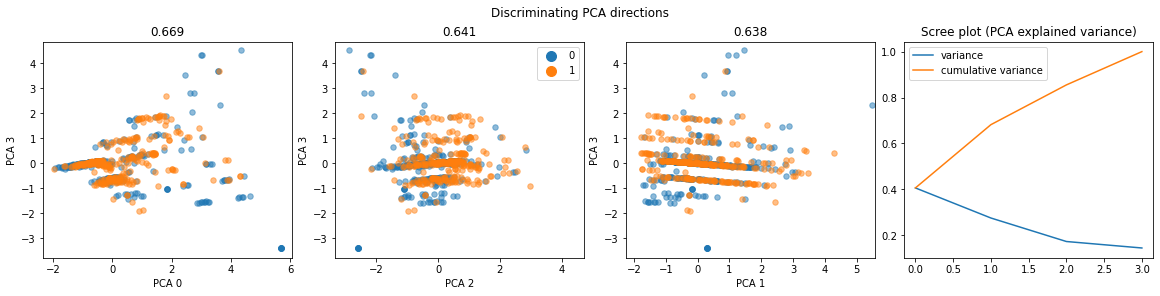

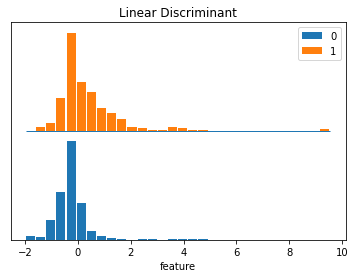

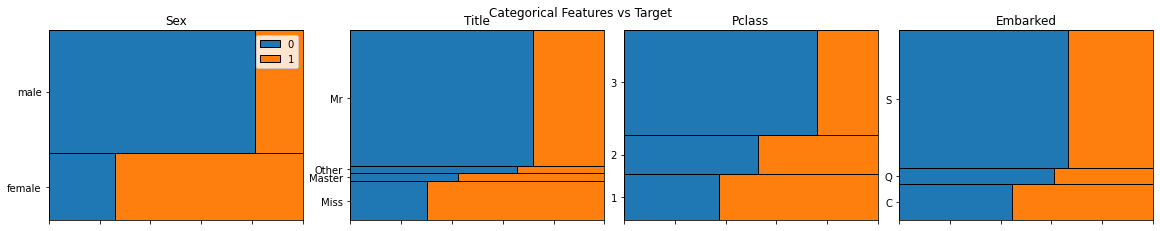

In [28]:
dabl.plot(train_df, 'Survived')
plt.show()

## Machine Learning Modelling

In [29]:
# With Dabl
fc = dabl.SimpleClassifier(random_state=0)
X = train_df.drop("Survived", axis=1)
y = train_df.Survived
fc.fit(X, y) 

Running DummyClassifier()
accuracy: 0.618 average_precision: 0.382 roc_auc: 0.500 recall_macro: 0.500 f1_macro: 0.382
=== new best DummyClassifier() (using recall_macro):
accuracy: 0.618 average_precision: 0.382 roc_auc: 0.500 recall_macro: 0.500 f1_macro: 0.382

Running GaussianNB()
accuracy: 0.416 average_precision: 0.712 roc_auc: 0.814 recall_macro: 0.525 f1_macro: 0.340
=== new best GaussianNB() (using recall_macro):
accuracy: 0.416 average_precision: 0.712 roc_auc: 0.814 recall_macro: 0.525 f1_macro: 0.340

Running MultinomialNB()
accuracy: 0.795 average_precision: 0.781 roc_auc: 0.834 recall_macro: 0.783 f1_macro: 0.782
=== new best MultinomialNB() (using recall_macro):
accuracy: 0.795 average_precision: 0.781 roc_auc: 0.834 recall_macro: 0.783 f1_macro: 0.782

Running DecisionTreeClassifier(class_weight='balanced', max_depth=1)
accuracy: 0.786 average_precision: 0.628 roc_auc: 0.766 recall_macro: 0.766 f1_macro: 0.770
Running DecisionTreeClassifier(class_weight='balanced', max_d

SimpleClassifier(random_state=0)

Design modelling with Decision tree and Logistic Regression with Balanced Class strategies

## Design Dataset 

In [30]:
## Design Training set 
#pd.get_dummies(train_df['Embarked'],prefix='Embarked')
train_df['Title_enc'] = LabelEncoder().fit_transform(train_df['Title'])
train_df['Sex'] = LabelEncoder().fit_transform(train_df['Sex'])
train_dataset = pd.concat([train_df.drop(['Embarked','Title'],axis=1),train_df['Title_enc'],pd.get_dummies(train_df['Embarked'],prefix='Embarked')],axis=1)
train_dataset['Age'] = train_dataset['Age'].astype('int')
train_dataset.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Title_enc,Title_enc,Embarked_C,Embarked_Q,Embarked_S
0,0,3,1,22,1,0,7.2500,2,2,0,0,1
1,1,1,0,38,1,0,71.2833,2,2,1,0,0
2,1,3,0,26,0,0,7.9250,1,1,0,0,1
3,1,1,0,35,1,0,53.1000,2,2,0,0,1
4,0,3,1,35,0,0,8.0500,2,2,0,0,1


In [31]:
## Design Testing Set
#test_df = pd.read_csv('../data/titanic/test.csv')
test_df['Title'] = test_df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
test_df['Title_enc'] = LabelEncoder().fit_transform(test_df['Title'])
test_df['Sex'] = LabelEncoder().fit_transform(test_df['Sex'])
test_dataset = pd.concat([test_df.drop(['Embarked','Title'],axis=1),test_df['Title_enc'],pd.get_dummies(test_df['Embarked'],prefix='Embarked')],axis=1)
iter_imputer = IterativeImputer(random_state=42)
titanic_iter_imputed = pd.DataFrame(iter_imputed, columns=expr_cols)
iter_imputed = iter_imputer.fit_transform(test_dataset[expr_cols])
titanic_iter_imputed = pd.DataFrame(iter_imputed, columns=expr_cols)
titanic_iter_imputed['Age'] =titanic_iter_imputed['Age'].astype('int')
test_dataset['Age']=titanic_iter_imputed['Age']
test_dataset["Fare"] = test_dataset["Fare"].fillna(test_dataset["Fare"].median())
test_dataset = test_dataset.drop(['Name','Ticket','Cabin'], axis=1)



In [32]:
X_train = train_dataset.drop("Survived", axis=1)
Y_train = train_dataset["Survived"]
X_test  = test_dataset.drop(columns='PassengerId').copy()
X_train.shape, Y_train.shape, X_test.shape

((889, 11), (889,), (418, 11))

### Logistic regression

In [35]:
from sklearn.metrics import f1_score
from sklearn.metrics import PrecisionRecallDisplay
from sklearn import metrics

In [36]:
lr = LogisticRegression(solver='newton-cg', class_weight='balanced')
lr.fit(X_train, Y_train)
pred_test = lr.predict(X_test)
#round(lr.score(X_train, Y_train) * 100, 2)
print("Accuracy:",metrics.accuracy_score(sub['Survived'], pred_test))

Accuracy: 0.7009569377990431


## Decision Tree

In [37]:
dt = DecisionTreeClassifier()
dt.fit(X_train, Y_train)
Y_pred = dt.predict(X_test)
print("Accuracy:",metrics.accuracy_score(sub['Survived'], Y_pred))


Accuracy: 0.777511961722488


### Fine Tuning Logistic Regression

In [ ]:
# Fine tuninung Logistic regression
parameters = {
    'penalty' : ['l1','l2','elasticnet'], 
    'C'       : np.logspace(-5,5,100),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear','sag','saga'],
}

In [ ]:
lr = LogisticRegression()
clf = GridSearchCV(lr,                    
                   param_grid = parameters,
                   scoring='accuracy',     
                   cv=10)    
clf.fit(X_train,Y_train)
print("Tuned Hyperparameters :", clf.best_params_)
print("Accuracy :",clf.best_score_)

### Fine Tuning Decision Tree 

In [40]:
max_depths = np.linspace(1, 30, 30, endpoint=True)

params = {
    'max_depth': max_depths.astype('int'),
    'min_samples_leaf': np.linspace(0.05, 0.9, 36, endpoint=True),
    'max_features' : list(range(1,X_train.shape[1])),
    'criterion': ["gini", "entropy"]
}

cl = GridSearchCV(dt,                    
                   param_grid = params,
                   scoring='accuracy',     
                   cv=10)   
cl.fit(X_train,Y_train)
print("Tuned Hyperparameters :", cl.best_params_)
print("Accuracy :",cl.best_score_) 

Tuned Hyperparameters : {'criterion': 'entropy', 'max_depth': 29, 'max_features': 7, 'min_samples_leaf': 0.05}
Accuracy : 0.8188840653728293


In [41]:
dt_best = cl.best_estimator_
Y_pred = dt_best.predict(X_test)
print("Accuracy:",metrics.accuracy_score(sub['Survived'], Y_pred))

Accuracy: 0.9019138755980861


## Sampling Estrategy

In [42]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler 

## Smote

In [44]:
sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1234)
X_train_over, y_train_over = sm.fit_resample(X_train, Y_train)
dt_best.fit(X_train_over,y_train_over)
Y_pred = dt_best.predict(X_test)
print("Accuracy:",metrics.accuracy_score(sub['Survived'], Y_pred))


Accuracy: 0.9952153110047847


## Undersampling

In [46]:
rus = RandomUnderSampler(random_state=1)
X_train_un, y_train_un = rus.fit_resample(X_train, Y_train)
dt_best.fit(X_train_un,y_train_un)
Y_pred = dt_best.predict(X_test)
print("Accuracy:",metrics.accuracy_score(sub['Survived'], Y_pred))

Accuracy: 0.9449760765550239


## Class weights 

In [47]:
from sklearn.ensemble import RandomForestClassifier
count_class_1 = Y_train.value_counts()[0]
count_class_2 = Y_train.value_counts()[1]
ratio = count_class_1/count_class_2
rf_estimator = RandomForestClassifier(class_weight={1:ratio, 0:1})
rf_estimator

RandomForestClassifier(class_weight={0: 1, 1: 1.6147058823529412})

In [48]:
dt_class_weights = DecisionTreeClassifier(criterion ='entropy', max_depth= 29, max_features= 7, min_samples_leaf= 0.05,class_weight={0: 1, 1: 1.6147058823529412})
dt_class_weights.fit(X_train, Y_train)
Y_pred = dt_class_weights.predict(X_test)
print("Accuracy:",metrics.accuracy_score(sub['Survived'], Y_pred))

Accuracy: 0.9473684210526315


## Final Model

In [49]:
sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1234)
X_train_over, y_train_over = sm.fit_resample(X_train, Y_train)
dt_best.fit(X_train_over,y_train_over)
Y_pred = dt_best.predict(X_test)
print("Accuracy:",metrics.accuracy_score(sub['Survived'], Y_pred))


Accuracy: 0.84688995215311


In [50]:
len(Y_pred)

418

In [ ]:
test_df_f = pd.read_csv('../data/titanic/test.csv')
test_df_f['PassengerId']

In [ ]:
# submission = pd.DataFrame({
#         "PassengerId": test_df_f['PassengerId'],
#         "Survived": Y_pred
#     })